# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import pandas as pd

# 2. Keypoints using MP Holistic

importiamo il modello Holistic di MediaPipe

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_drawing_styles = mp.solutions.drawing_styles

funzione di riconoscimento: convertiamo prima l'immagine dal canale BGR (output di OpenCV feed) a quello RGB, necessario per MediaPipe;
alla fine riconvertiamo in BGR

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction with the Holistic model
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

ora visualizziamo i landmark graficamente, in maniera standard; li renderizziamo -> saranno visibili a schermo

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

#le X_CONNECTIONS sono mappe che restituiscono i legami fra i vari landmark

formattiamo, personalizziamo i landmark in maniera grafica

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                             ) 

# 3. Extract Keypoint Function

restituisce il numero dei landmark usati per la parte del corpo specificata

Lavoriamo su ciascun landkmark: 

- creiamo degli array dove memorizzare le sue coordinate (dei landmark)

- Useremo degli array di zero quando una certa parte del corpo non è riconosciuta/presente, per non fare andare in errore il sistema.

Facciamo la stessa cosa, ma tutto su una sola linea.

**N.B.** usiamo *flatten()* perchè vogliamo un solo array, unidimensionale, perchè ci servirà questo formato per la LSTM; infatti, senza flatten() avremo una matrice, un array bidimensionale (ciascun landmark avrà *x* valori associati)

come abbiamo detto prima, creiamo un array vuoto (di zeri), per gestire l'errore nel caso in cui una parte del corpo non è riconosciuta.

qui facciamo quello fatto sopra, ma in maniera pù organizzata, in una funzione apposita:

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

nello specifico:

res.x, res.y, res.z sono i singoli valori delle coord. per ciascun landmark, che verranno inseriti in un array più grande, ciclando per ogni landmark:

- se non esistono coordinate per i landmark, quindi quella parte del corpo non è riconosciuta, viene creato un array vuoto

### abbiamo estratto i **keypoints** per il frame di interesse, che saranno utili per il riconoscimento dei gesti/segni

# 4. Setup Folders

In [51]:
os.chdir("../mytempfiles")

quali sono i gesti contenuti nel dataset?

In [6]:
labels_file = pd.read_csv(r'D:\TMS\dataset\jester\labels\labels.csv') #TODO rel path

gestures = labels_file['labels'].tolist() #metto in una lista tutte le labels del dataset
gestures_array = np.array(gestures)

memorizzo la lista di tutti i video disponibili

In [ ]:
DATADIR = r'D:\TMS\dataset\jester\20bn-jester-v1'

list_video = sorted(os.listdir(DATADIR), key=len) #li voglio ordinati così come compaiono nell'explorer dei file
list_video

In [8]:
list_video_int = list(map(int, list_video)) #converto tutto in int da string
len(list_video_int)

37793

creo fold in cui salvare keypoints, per ogni video

In [ ]:
for vid in list_video: #per ogni video
        try: 
            os.makedirs(os.path.join(DATADIR, str(vid), "keypoints"))
        except:
            pass #se esistono già, skippa la creazione

creo ora folds dei gesti, dove salvaremo ogni video in cui la stessa è performata

In [ ]:
for label in gestures: #per ogni label (per ogni gesto)
    try:
        os.makedirs(os.path.join(DATADIR, label))
    except:
        pass #se esistono già, skippa la creazione

ora dovremmo spostare in queste cartelle i relativi video

# 5. Collect Keypoint Values from the dataset for Training and Testing

❗❗ Estrarremo i keypoints dai frame di ciascun video presente nel **dataset** *Jester*

Struttura del dataset Jester:

- **VIDEO:** 148092
    - **FRAME x video:** circa 30
        - *FPS:* 12, un frame ogni 12 s
        - *altezza:* 100px

Il dataset, contenente **148092** video, è inoltre già splittato negli insiemi di **Training, Test e Validation:**

- **TRAINING videos:** 118562 
- **TEST videos:** 14743 
- **VALIDATION videos:** 14787 

Il dataset conterrà **27** labels (classi) di gesti diversi

otteniamo i video per il **training** del modello:

In [ ]:
train_file = pd.read_csv(r'D:\TMS\dataset\jester\labels\train.csv', delimiter=";") #TODO path relativo

train_list = train_file['key'].tolist() #lista degli indici dei video attualmente estratti
train_file

otteniamo ora i video per il **testing** del modello:

In [ ]:
test_file = pd.read_csv(r'D:\TMS\dataset\jester\labels\test-answers.csv', delimiter=";") #TODO path relativo

test_list = test_file['key'].tolist() #lista degli indici dei video attualmente estratti
test_file = test_file.loc[:, ~test_file.columns.str.contains('^Unnamed')]  #cancello colonne non necessarie
test_file

### **N.B.** Vediamo ora come selezionare i frame dal dataset scelto, già estratti dai video

#### *prima però bisogna considerare che non ho estratto dall'archivio .tar tutti i video ...*

- vediamo prima il **training set**

In [24]:
count = 0
my_train_list = [] #lista che contiene i miei video di training, attualmente disponibili

#mostra tutti gli indici dei video attualmente estratti dall'archivio tar, convertiti in integers
list_video_int = list(map(int, list_video))

for vid in list_video_int:
    for train_vid in train_list:
        if vid == train_vid:
            count += 1     
            my_train_list.append(vid)

attualmente, abbiamo **30228** video di training su 37793 totali (80% circa)

In [25]:
np.save("mytrainlist", my_train_list)

In [52]:
my_train_list = np.load("mytrainlist.npy").tolist()
my_train_list
len(my_train_list)

30228

In [53]:
my_train_file = train_file.query('key in @my_train_list') #sottoinsieme di train_file, che contiene solo i video di training attualm. disponibili
train_list2 = sorted(my_train_file['key'].tolist())  #lista degli indici dei video di training attualmente disponibili

my_train_file

,key,value
2,129112,Sliding Two Fingers Down
4,131717,Sliding Two Fingers Up
5,23595,Zooming Out With Two Fingers
6,93002,Pulling Hand In
7,136859,Thumb Up
...,...,...
118540,106904,Doing other things
118541,96650,Sliding Two Fingers Down
118544,43396,Thumb Down
118550,132112,Swiping Up


controllo effettivamente se le liste sono uguali: in tal caso tengo conto solamente di una delle due

In [12]:
if(set(my_train_list) == set(train_list2)):
    print("Lists are equal")
else:
    print("Lists are not equal")

Lists are equal


- facciamo lo stesso per il **test set**

In [19]:
count = 0
my_test_list = [] #lista che contiene i miei video di test, attualmente disponibili

#mostra tutti gli indici dei video attualmente estratti dall'archivio tar, convertiti in integers
list_video_int = list(map(int, list_video))

for vid in list_video_int:
    for test_vid in test_list:
        if vid == test_vid:
            count += 1     
            my_test_list.append(vid)

attualmente abbiamo **3763** video di test su 37793 totali (10% circa)

In [17]:
np.save("mytestlist", my_test_list)

In [54]:
my_test_list = np.load("mytestlist.npy").tolist()
len(my_test_list)

3763

In [55]:
my_test_file = test_file.query('key in @my_test_list') #sottoinsieme di test_file, che contiene solo i video di testing attualm. disponibili
my_test_list2 = sorted(my_test_file['key'].tolist())  #lista degli indici dei video di testing attualmente disponibili

my_test_file

,key,value
0,115190,Turning Hand Counterclockwise
4,138995,Thumb Down
6,60037,Pushing Two Fingers Away
8,106678,Swiping Up
9,139247,Drumming Fingers
...,...,...
14724,17730,Drumming Fingers
14727,78775,Pulling Two Fingers In
14730,35240,Swiping Up
14731,131876,Thumb Down


In [15]:
if(set(my_test_list) == set(my_test_list2)):
    print("Lists are equal")
else:
    print("Lists are not equal")

Lists are equal


##### ----------------------------------------------------------------------------------------------------------------------------------------------------

### Genero nuovi frame per ogni video se esso non raggiunge i 30 frame, copiandone l'ultimo, ripetutamente

In [72]:
def get_num_frames(path):   

    # restituisce tutti gli elementi nel path indicato, nel nostro caso tutti i frame per il video specificato con il suo path
    frames_4_video = os.listdir(path)        
    num_frames = len(frames_4_video) - 1 #togliamo 1 perchè non consideriamo la fold dei keypoints
    print("Numero frame per questo video:", num_frames)

    return num_frames

In [73]:
def get_last_frame(path):

    frames_4_video = os.listdir(path)
    last_frame = frames_4_video[-2] #prendiamo l'ultimo frame
    print("\nnome ultimo frame:", last_frame)
    img_path = os.path.join(path, last_frame)
    img_array = cv2.imread(img_path) 

    return last_frame, img_array

In [74]:
def create_name_frame(last_frame):
    num_frame = last_frame[3:5] #prendo solamente i char 3, 4 perchè mi interessa il numero del frame
    num_frame = int(num_frame) + 1
    last_frame = "000" + str(num_frame) + ".jpg"
    return last_frame

In [ ]:
DATADIR = r'D:\TMS\dataset\jester\20bn-jester-v1'

for vid in list_video_int:

    path = os.path.join(DATADIR, str(vid))  
    os.chdir(path)  

    num_frames = get_num_frames(path)    

    if num_frames < 30:
        
        print("Percorso video:", path)
        print("\nNumero frame per questo video:", num_frames)
        
        while num_frames < 30:

            last_frame, img_array = get_last_frame(path)
            last_frame = create_name_frame(last_frame)                    
            cv2.imwrite(last_frame, img_array) #salvo nella fold il "nuovo" frame, ovvero una copia dell'ultimo frame

            num_frames += 1
            print("numero frame aggiornato:", num_frames) 
    else:
        print("il video ha già almeno 30 frame")       
    

-------------------------------------------------------------------------------------------------------------------------------

- ### accedo ai frame di ogni video e ne estraggo i keypoints

estraggo e memorizzo i keypoints

In [75]:
def detect_and_extract(img_array, model):    
    
    image, results = mediapipe_detection(img_array, model)
    #draw_styled_landmarks(image, results)
    #print(results)
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))                    
    keypoints = extract_keypoints(results)
    return keypoints

inizializzazione liste

In [76]:
DATADIR = r'D:\TMS\dataset\jester\20bn-jester-v1'

actual_train_video = []
actual_test_video = []
actual_video = []

In [77]:
def get_num_keypoints(path):
    keypoints_path = os.path.join(path, 'keypoints')
    num_keypoints = len(os.listdir(keypoints_path)) #indica quanti keypoints sono stati estratti 
    
    return num_keypoints 

In [78]:
def get_and_append_img(path, img, all_frames):

    img_num = img[0:5] #prendo i primi N char, per non avere l'estensione nel nome quando salvo dopo
    img_path = os.path.join(path, img)
    img_array = cv2.imread(img_path)  # convert to array
    print(img_path)                    
    all_frames.append(img)

    return img_array, img_num

In [79]:
def access_frames(list, num_videos, actual_video_type):

    with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:

        for vid in list[0:num_videos]:  # itero su tutti i video (i primi 1500)...

            all_frames = []

            # create path (...\20bn-jester-v1\000xx)
            path = os.path.join(DATADIR, str(vid))
            print("\nPercorso video:", path)

            frames_4_video = os.listdir(path)
          
            num_frames = get_num_frames(path)        
            num_keypoints = get_num_keypoints(path) #indica quanti keypoints sono stati estratti   
            
            # esegui se non tutti i keypoints sono stati ancora estratti da ciascun frame 
            if num_keypoints != num_frames:            
                
                # iterate over each image (00001, 00002, ...)
                for img in frames_4_video:            
                            
                    if not img == 'keypoints': #non considero la cartella dove salvo i keypoints (TODO potrei farlo prima, escludendo la cartella)
                                        
                        img_array, img_num = get_and_append_img(path, img, all_frames)

                        keypoints = detect_and_extract(img_array, holistic)

                        # salvo i keypoints su disco
                        npy_path = os.path.join(DATADIR, str(vid), "keypoints", img_num)
                        np.save(npy_path, keypoints)
                
            else:
                print("N.B. keypoints già estratti per questo video")
                actual_video_type.append(vid)
                actual_video.append(vid)

In [ ]:
access_frames(my_train_list, 1500, actual_train_video) #accedo ai frame dei video di train..
access_frames(my_test_list, 700, actual_test_video) #.. e per quelli di test

opero altra suddivisione per **TRAINING SET** ottenendo il file su cui **classificare**

In [60]:
my_train_file2 = my_train_file.query('key in @actual_train_video') #contiene indice e label dell'azione associata a quel video
my_train_file2.sort_values(["key"], axis=0, ascending=[True], inplace=True) #ordino gli elem in modo crescente in base al valore dell'idx del video 
np.save("mytrainfile2", my_train_file2)

my_train_file2 #questo è il file su cui devo lavorare come training set

C:\Users\follo\AppData\Local\Temp\ipykernel_7648\2135385370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_train_file2.sort_values(["key"], axis=0, ascending=[True], inplace=True) #ordino gli elem in modo crescente in base al valore dell'idx del video


,key,value
59351,4,Swiping Right
82397,6,Drumming Fingers
106437,10,Thumb Down
69146,12,Sliding Two Fingers Down
69109,20,Doing other things
...,...,...
117925,7361,Zooming In With Full Hand
55587,7362,Sliding Two Fingers Down
63869,7365,Pulling Hand In
116003,7366,Zooming Out With Two Fingers


abbiamo dunque **1500** video di training su cui addestrare il modello

facciamo lo stesso per i video di **TEST**:

In [ ]:
my_test_file2 = my_test_file.query('key in @actual_test_video') #contiene indice e label dell'azione associata a quel video
my_test_file2.sort_values(["key"], axis=0, ascending=[True], inplace=True) #ordino gli elem in modo crescente in base al valore dell'idx del video 
np.save("mytestfile2", my_test_file2)

my_test_file2 #questo è il file su cui devo lavorare come training set

ho **700** video di test al momento su cui testare il modello

In [62]:
np.save("actualvideo", actual_video)
np.save("actual_test_video", actual_test_video)
np.save("actual_train_video", actual_train_video)

In [90]:
actual_video = np.load("actualvideo.npy")
actual_train_video = np.load("actual_train_video.npy")
actual_test_video = np.load("actual_test_video.npy")

In [91]:
actual_video = sorted(actual_video)
len(actual_video)

2200

ho quindi a disposizione **2200** video totali per il momento

----------------------------------------------------------------------------------------------------------------------------

#### **TEST 2:** prendo una precisa immagine dal dataset

In [ ]:
DATADIR2 = r'D:\TMS\dataset\jester\20bn-jester-v1\7367'

# OTTENGO I FRAME    
path = os.path.join(DATADIR2, '00018.jpg')  # create path (...\Color\rgb1)
frame = cv2.imread(path)  # convert to array
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))      

- provo con modello *Holistic*

In [ ]:
# ESTRAGGO I KEYPOINTS DA UN FRAME
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    image, results = mediapipe_detection(frame, holistic)
    draw_styled_landmarks(image, results)
    print(results)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  

    keypoints = extract_keypoints(results) #memorizzo i keypoints estratti    

In [33]:
keypoints

array([ 0.54351187,  0.50962019, -1.12005699, ...,  0.        ,
        0.        ,  0.        ])

In [34]:
keypoints.shape    

(1662,)

abbiamo 1662 keypoints per ogni frame

- provo solamente con modello *Hands*

In [ ]:
# ESTRAGGO I KEYPOINTS DA CIASCUN FRAME
with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
    image, results = mediapipe_detection(frame, hands)
    
    annotated_image = image.copy()
    
    for hand_landmarks in results.multi_hand_landmarks:        

        mp_drawing.draw_landmarks(     
            annotated_image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
            )

    print(results)
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))   

# 6. Preprocess Data and Create Labels and Features

In [59]:
#from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

creiamo un dizionario dove salviamo tutte le azioni/gesti:

In [60]:
label_map = {label:num for num, label in enumerate(gestures)} #iteriamo su ciascuna azione

In [ ]:
label_map

In [ ]:
my_test_file2

In [ ]:
my_train_file2

strutturiamo i dati fin ora raccolti, inserendoli in un unico array

qui cicliamo separatamente per i video di training e test, avendoli già divisi:

In [92]:
def insert_all_in_array(actual_video_type):

    videos_type = [] # rispettivamente X (feature input) e Y (feature target)

    for vid in actual_video_type: #np.array(os.listdir(os.path.join(DATADIR))).astype(int): #cast str to int
        
        window_type = [] #rappresenta un unico video: insieme di X frame

        num_frames = len(os.listdir(os.path.join(DATADIR, str(vid))))
        #print(num_frames)

        for frame_num in range(1, 31): #range(1, num_frames): #itero per tutti i frame estratti per quel video        
            #faccio if perchè gli array dei keypoint sono salvati come '000xx.npy' e non come 'x.npy'-> #TODO rinominarli
            if frame_num < 10:
                res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "0000{}.npy".format(frame_num)))
                window_type.append(res)
            else:
                res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "000{}.npy".format(frame_num)))
                window_type.append(res)

        videos_type.append(window_type)    
        #labels.append(label_map[action]) #TODO come associare la label a ogni video??
        # array monodimensionale (ci dice per ogni video quale azione è presente al suo interno: la prima, ... -> definizione di LABEL)

    return videos_type, window_type

In [ ]:
train_videos, train_window = insert_all_in_array(actual_train_video)
test_videos, test_window = insert_all_in_array(actual_test_video)

In [92]:
train_videos, labels = [], [] # rispettivamente X (feature input) e Y (feature target)

for vid in actual_train_video: #np.array(os.listdir(os.path.join(DATADIR))).astype(int): #cast str to int
    
    train_window = [] #rappresenta un unico video: insieme di X frame

    num_frames = len(os.listdir(os.path.join(DATADIR, str(vid))))
    #print(num_frames)

    for frame_num in range(1, 31): #range(1, num_frames): #itero per tutti i frame estratti per quel video        
        #faccio if perchè gli array dei keypoint sono salvati come '000xx.npy' e non come 'x.npy'-> #TODO rinominarli
        if frame_num < 10:
            res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "0000{}.npy".format(frame_num)))
            train_window.append(res)
        else:
            res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "000{}.npy".format(frame_num)))
            train_window.append(res)

    train_videos.append(train_window)    
    #labels.append(label_map[action]) #TODO come associare la label a ogni video??
    # array monodimensionale (ci dice per ogni video quale azione è presente al suo interno: la prima, ... -> definizione di LABEL)

In [91]:
test_videos, labels = [], [] # rispettivamente X (feature input) e Y (feature target)

for vid in actual_test_video: #np.array(os.listdir(os.path.join(DATADIR))).astype(int): #cast str to int
    
    test_window = [] #rappresenta un unico video: insieme di X frame

    num_frames = len(os.listdir(os.path.join(DATADIR, str(vid))))
    #print(num_frames)

    for frame_num in range(1, 31): #range(1, num_frames): #itero per tutti i frame estratti per quel video        
        #faccio if perchè gli array dei keypoint sono salvati come '000xx.npy' e non come 'x.npy'-> #TODO rinominarli
        if frame_num < 10:
            res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "0000{}.npy".format(frame_num)))
            test_window.append(res)
        else:
            res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "000{}.npy".format(frame_num)))
            test_window.append(res)

    test_videos.append(test_window)    
    #labels.append(label_map[action]) #TODO come associare la label a ogni video??
    # array monodimensionale (ci dice per ogni video quale azione è presente al suo interno: la prima, ... -> definizione di LABEL)

In [93]:
np.save("test_videos", test_videos)
np.save("train_videos", train_videos)

In [39]:
train_videos = np.load("train_videos.npy")
test_videos = np.load("test_videos.npy")

In [94]:
np.array(train_videos).shape

(1500, 30, 1662)

In [95]:
np.array(test_videos).shape

(700, 30, 1662)

In [72]:
len(train_videos)

1500

In [73]:
np.array(train_window).shape

(29, 1662)

In [ ]:
np.array(test_window).shape

In [96]:
X_train = np.array(train_videos)
X_test = np.array(test_videos)

In [97]:
X_train

array([[[ 0.46541679,  0.32155907, -1.08207655, ...,  0.81472546,
          0.65358049, -0.04572884],
        [ 0.46303397,  0.32168567, -1.05936861, ...,  0.80941516,
          0.65668797, -0.05767181],
        [ 0.46250632,  0.32292056, -1.06126773, ...,  0.82418782,
          0.65296018, -0.08247977],
        ...,
        [ 0.48329383,  0.30790797, -0.92843956, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.48273849,  0.30779856, -0.95394254, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.48233196,  0.30767581, -0.96440369, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.53745127,  0.38466668, -1.10468328, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.53816277,  0.38626516, -1.10591042, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.53857571,  0.38723904, -1.11641681, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.56829911,  0.41339961, -1.13434994, ...,  

In [84]:
#X = np.array(videos, dtype=object)

In [76]:
X_train.shape

(1500, 29, 1662)

In [98]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label_train = le.fit_transform(my_train_file2['value']) 
label_test = le.fit_transform(my_test_file2['value'])

In [99]:
label_test

array([ 5,  1, 24,  6,  4,  2,  8, 19,  9, 17,  0,  1, 22,  8, 23,  8, 15,
        0,  9, 13,  0, 18,  0, 20, 11, 14, 21,  3,  8, 16,  0,  7, 21, 18,
       16, 17, 13, 18, 12, 14, 25,  6, 18, 23,  0,  9, 16,  4,  5, 13,  9,
       24,  0, 15,  0,  0, 10, 20,  8, 17, 21, 11, 10,  8, 23, 26,  6,  3,
       24, 10, 10,  2,  7, 14, 11, 16, 26,  9, 10, 24, 14, 16, 26, 22, 26,
        6, 14, 11, 17, 13,  1, 24, 11,  9,  0,  3,  0, 14, 12, 12, 14,  9,
       24,  2, 20, 16,  3, 21, 17, 24, 20,  9, 12,  0, 22, 25,  6,  9, 25,
        3, 11, 19,  0,  9,  8,  2, 13, 25, 13,  8, 24, 19, 13, 15,  4, 22,
        1, 22, 14,  3,  6, 10, 15, 26, 25, 12,  5, 13,  7, 25,  8, 24, 10,
       25, 11,  3, 24,  0, 21,  6, 24,  5,  0,  0, 16, 11, 25,  9, 21, 13,
       23, 23,  0,  5, 15,  2,  4, 12,  0, 21,  2, 22,  0, 20,  5, 14,  0,
        0, 20,  3,  5, 21, 14, 19,  6,  6, 23,  8,  3, 10, 19, 26, 11,  0,
       23, 16, 20, 23,  0, 13,  2, 23,  9, 15,  9, 18,  4,  6, 12,  3, 17,
       19, 18, 26,  1, 14

In [79]:
my_train_file3 = my_train_file2.copy()
my_train_file3.drop("value", axis=1, inplace=True)
 
# Appending the array to our dataFrame
# with column name 'Purchased'
my_train_file3["value"] = label_train
 
# printing Dataframe
my_train_file3

,key,value
59351,4,17
82397,6,1
106437,10,19
69146,12,10
69109,20,0
...,...,...
117925,7361,23
55587,7362,10
63869,7365,3
116003,7366,26


In [100]:
my_test_file3 = my_test_file2.copy()
my_test_file3.drop("value", axis=1, inplace=True)
 
# Appending the array to our dataFrame
# with column name 'Purchased'
my_test_file3["value"] = label_test
 
# printing Dataframe
my_test_file3

,key,value
9037,18,5
8174,126,1
13137,199,24
13477,231,6
8499,281,4
...,...,...
7464,27847,11
840,27866,25
7730,27919,9
9124,27995,0


In [ ]:
label_train = np.array(my_train_file3["value"]).tolist()
label_train

In [ ]:
label_test = np.array(my_test_file3["value"]).tolist()
label_test

trasformo feature categoriche in feature numeriche (One Hot Encoding)

In [101]:
y_train = to_categorical(label_train).astype(int)
y_test = to_categorical(label_test).astype(int)

In [ ]:
#y = to_categorical(labels).astype(int)

splittiamo i dati in Training Sets e Test Sets (in questo dataset sono già splittati)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,stratify=y)

In [102]:
print(y_train.shape)
print(y_test.shape) #27 sono le classi

(1500, 27)
(700, 27)


# 7. Build and Train LSTM Neural Network

Addestriamo la rete neurale (ricorrente) **LSTM**: 

- perchè usare MediaPipe Holistic + una rete neurale LSTM?
    - occorrono *meno dati*
    - più *veloce* nell'addestramento
    - riconoscimento più *veloce* <- RN più *semplice*

In [85]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard

**TensorBoard** ci offre una web app per monitorare il nostro modello: addestramento, accuratezza, ... 

In [104]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [103]:
gestures_array.shape

(27,)

In [106]:
# il modello Sequential ci permette di aggiungere layer in mainera organizzata e facile
model = Sequential()
#model.add(Masking(mask_value=0, input_shape=(None, 105)))
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape = (30,1662))) #64 unità
model.add(LSTM(128, return_sequences=True, activation='relu')) #return_sequences è necessario per il passaggio di dati al layer successivo
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(gestures_array.shape[0], activation='softmax')) #distribuzione di probabilità che assegna ad ogni azione una certa prob.

Compiliamo il modello, usando:

- loss function: "categorical cross entropy"
    - è obbligatoria per classificazione multi-classe

In [107]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [108]:
model_temp = model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
47/47 [==============================] - 18s 152ms/step - loss: 35.2136 - categorical_accuracy: 0.0320
Epoch 2/100
47/47 [==============================] - 7s 146ms/step - loss: 9.7698 - categorical_accuracy: 0.0420
Epoch 3/100
47/47 [==============================] - 7s 155ms/step - loss: 5.7288 - categorical_accuracy: 0.0333
Epoch 4/100
47/47 [==============================] - 7s 144ms/step - loss: 6.8102 - categorical_accuracy: 0.0393
Epoch 5/100
47/47 [==============================] - 7s 142ms/step - loss: 3.3340 - categorical_accuracy: 0.0387
Epoch 6/100
47/47 [==============================] - 7s 146ms/step - loss: 3.2925 - categorical_accuracy: 0.0773
Epoch 7/100
47/47 [==============================] - 7s 141ms/step - loss: 3.2892 - categorical_accuracy: 0.0820
Epoch 8/100
47/47 [==============================] - 7s 142ms/step - loss: 3.2865 - categorical_accuracy: 0.0820
Epoch 9/100
47/47 [==============================] - 7s 140ms/step - loss: 3.2843 - categorica

KeyboardInterrupt: 

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 27)                891       
                                                                 
Total params: 597,467
Trainable params: 597,467
Non-trai

# 8. Make Predictions

In [75]:
res = model.predict(X_test) #prendo tutte le predizioni dall'insieme di test
# res[0]: significa che prendo la prima prediction (quindi la prediction della prima azione presente in X_test)

22/22 [==============================] - 2s 29ms/step


poichè ad ogni azione è associata una probabilità, la mia predizione sarà quella che avrà probabilità **maggiore** fra esse

In [79]:
gestures_array[np.argmax(res[0])] #qual'è l'azione con il più altro valore di probabilità associato?

'Rolling Hand Forward'

prendo la label della 4a azione: vedo quindi il *ground truth*

In [78]:
gestures_array[np.argmax(y_test[0])]

'Pulling Hand In'

ovviamente, se le due azioni **coincidono** significa che il modello ha una **buona accuracy**

# 9. Save Weights

In [59]:
model.save('action2.h5')

In [ ]:
del model

In [ ]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [80]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [81]:
yhat = model.predict(X_test)

22/22 [==============================] - 1s 25ms/step


In [82]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [84]:
accuracy_score(ytrue, yhat)

0.045714285714285714

In [85]:
from sklearn.metrics import ConfusionMatrixDisplay

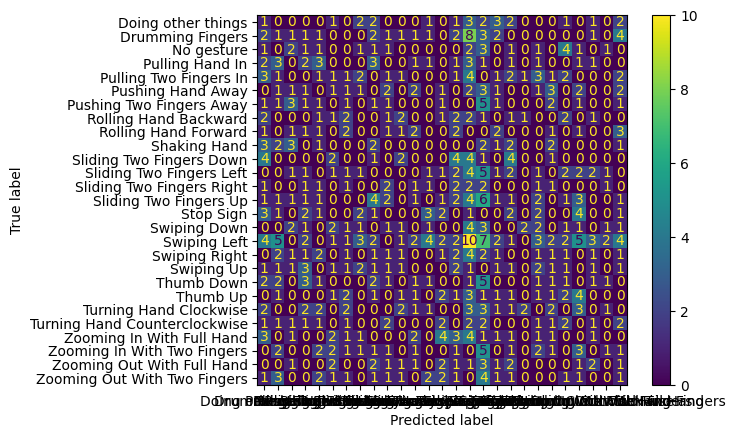

In [86]:
ConfusionMatrixDisplay.from_predictions(gestures_array[ytrue], gestures_array[yhat])

# 11. Test in Real Time

In [90]:
from scipy import stats

In [102]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        #cv2.rectangle(output_frame, (0,10+num*10), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 0.1, (255,255,255), 1, cv2.LINE_AA)
        
    return output_frame

In [96]:
res.shape

(27,)

In [185]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, gestures_array, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [1]:
# 1. New detection variables
sequence = []
predictions = []
gesto = ""
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(gestures_array[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:                     
                    gesto = gestures_array[np.argmax(res)]
             
            # Viz probabilities
            image = prob_viz(res, gestures_array, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(gesto), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

NameError: name 'cv2' is not defined